2023-12-14 08:21:24.482518: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:/usr/lib/nvidia
2023-12-14 08:21:24.482540: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


FileNotFoundError: [Errno 2] No such file or directory: '../docs/_static/merlion.png'

#### Preprocess image and text inputs

A fireman stood at the top of the ladder


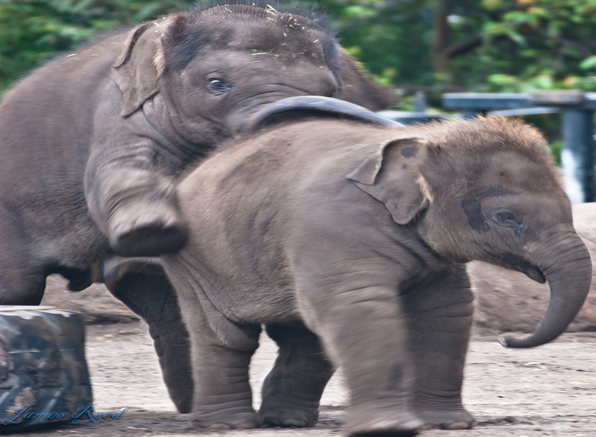

2023-12-14 08:23:43.745 | INFO     | lavis.models:load_model_and_preprocess:152 - Loading the preprocessors from the default config file...
2023-12-14 08:23:43.746 | INFO     | lavis.models:load_model_and_preprocess:153 - args:{'model': {'arch': 'blip_image_text_matching', 'load_finetuned': True, 'finetuned': 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_retrieval_coco.pth', 'vit_type': 'large', 'vit_grad_ckpt': False, 'vit_ckpt_layer': 0, 'image_size': 384, 'med_config_path': 'configs/models/med_large_config.json', 'embed_dim': 256}, 'preprocess': {'vis_processor': {'eval': {'name': 'blip_image_eval', 'image_size': 384}}, 'text_processor': {'eval': {'name': 'blip_caption'}}}}
2023-12-14 08:23:43.746 | INFO     | lavis.models:load_preprocess:96 - Visual pretrained model: {'eval': {'name': 'blip_image_eval', 'image_size': 384}} | Text pretrained model: {'eval': {'name': 'blip_caption'}}


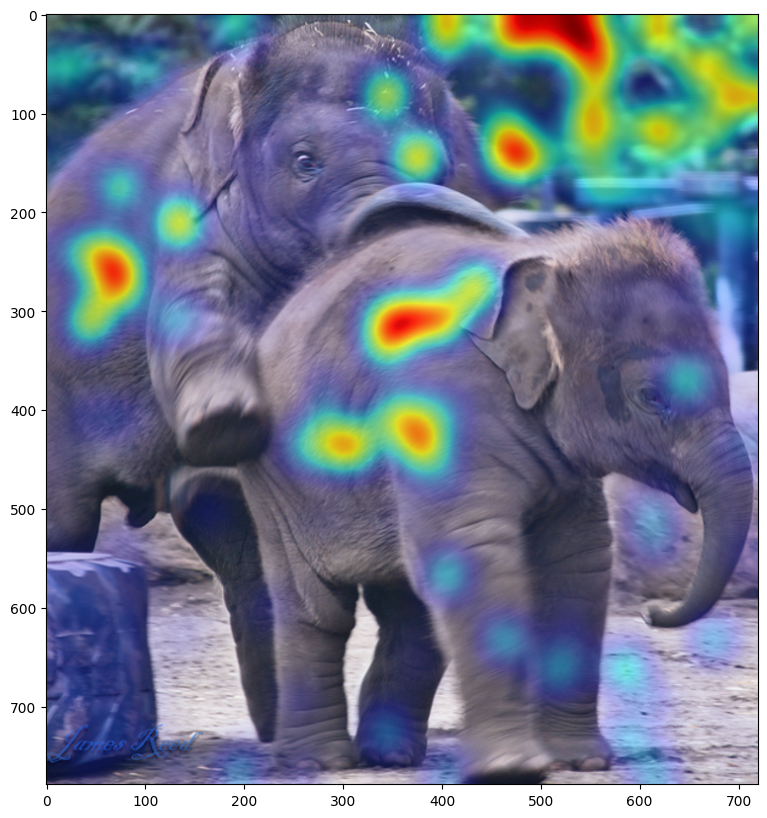

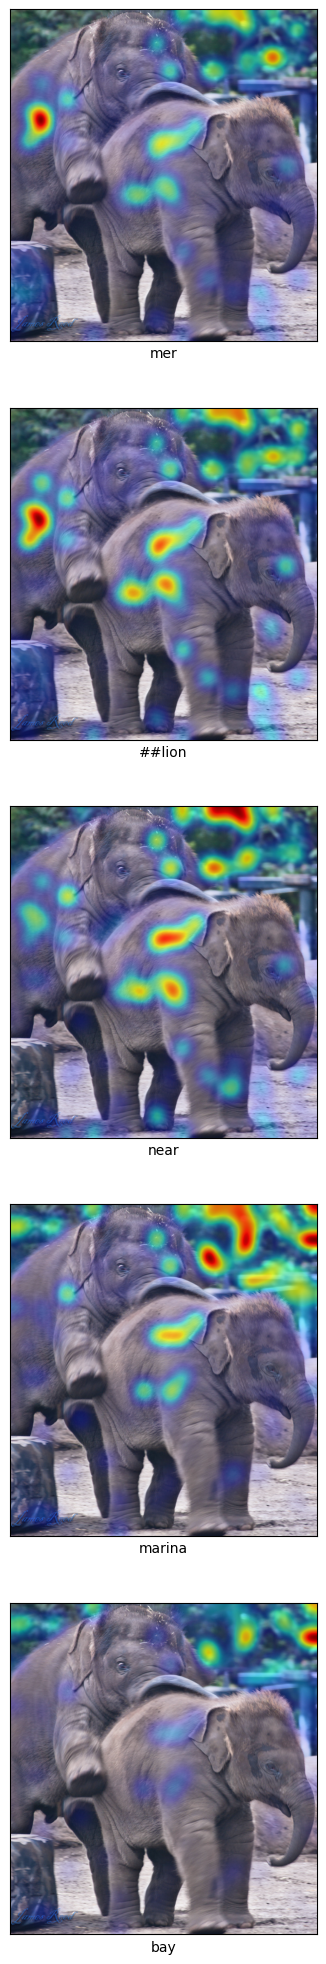

In [2]:
from matplotlib import pyplot as plt
from lavis.common.gradcam import getAttMap
from lavis.models.blip_models.blip_image_text_matching import compute_gradcam
import numpy as np
from pysaliency.external_datasets.sjtuvis import TextDescriptor
import pysaliency


import torch
from PIL import Image

import sys
# sys.path.append("../..")
from lavis.models import load_model_and_preprocess
from lavis.processors import load_processor

data_location = "../../datasets/test"
text_descriptor = TextDescriptor('../../datasets/test/original_sjtuvis_dataset/text.xlsx')
print(text_descriptor.get_description('000000020777_2.png')) 
mit_stimuli, mit_fixations = pysaliency.external_datasets.get_sjtu_vis("../../datasets/test/original_sjtuvis_dataset", location=data_location, text_descriptor=text_descriptor)


raw_image = Image.fromarray(mit_stimuli[10].stimulus_data)
display(raw_image.resize((596, 437)))
# setup device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
caption = "Merlion near marina bay."
model, vis_processors, text_processors = load_model_and_preprocess("blip_image_text_matching", "large", device=device, is_eval=True)

dst_w = 720
w, h = raw_image.size
scaling_factor = dst_w / w

resized_img = raw_image.resize((int(w * scaling_factor), int(h * scaling_factor)))
norm_img = np.float32(resized_img) / 255

img = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
txt = text_processors["eval"](caption)
txt_tokens = model.tokenizer(txt, return_tensors="pt").to(device)
gradcam, _ = compute_gradcam(model, img, txt, txt_tokens, block_num=7)
avg_gradcam = getAttMap(norm_img, gradcam[0][1], blur=True)
# fig, ax = plt.subplots(num_image, 1, figsize=(15,5*num_image))
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(avg_gradcam)

num_image = len(txt_tokens.input_ids[0]) - 2
fig, ax = plt.subplots(num_image, 1, figsize=(15, 5 * num_image))

gradcam_iter = iter(gradcam[0][2:-1])
token_id_iter = iter(txt_tokens.input_ids[0][1:-1])

for i, (gradcam, token_id) in enumerate(zip(gradcam_iter, token_id_iter)):
    word = model.tokenizer.decode([token_id])
    gradcam_image = getAttMap(norm_img, gradcam, blur=True)
    ax[i].imshow(gradcam_image)
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    ax[i].set_xlabel(word)

#### GradCam for each token

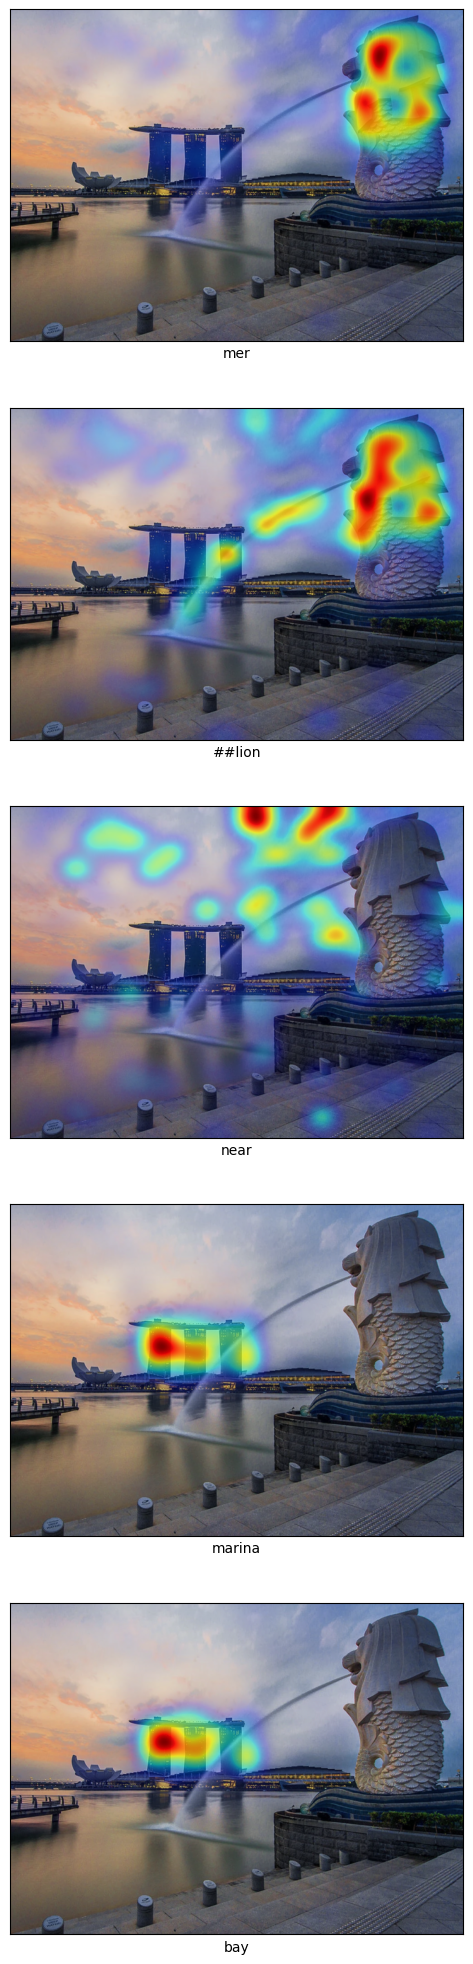